Code to generate Figures 4 and 5(a) in 'Rethinking Discount Regularization'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
#import seaborn as sns
import torch
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import random
import copy
import pickle

## Define MDP

In [ ]:
def define_mdp():

  """ Random MDP from "The Dependence of Effective Planning Horizonon Model Accuracy"

    Nan Jiang, Alex Kulesza, Satinder Singh, and Richard Lewis

    Generate new MDP for each iteration.

    For each state-actionpair(s,a), the distribution over the next state,P(s,a,·), isdetermined by choosing 5 non-zero entries uniformly from all  10  states,
      filling  these  5  entries  with  values  uniformlydrawn  from[0,1],  and  finally  normalizing P(s,a,·).

    The mean rewards were likewise sampled uniformly and indepen-dently from[0,1], and the actual reward signals have additive Gaussian noise with standard deviation 0.1.  --> WE ASSUME R KNOWN

    For all MDPs we fixedγeval= 0.99.

  """
  num_states = 10
  num_nonzeros_states = 5
  num_actions = 2
  T_list = []
  for a in range(num_actions):
    T = np.zeros((num_states,num_states))
    for state in range(num_states):
      nonzero_states = random.sample(range(num_states),num_nonzeros_states)
      for n in nonzero_states:
        T[state][n] = np.random.uniform(0,1,1)
      total_prob = sum(T[state])
      T[state] = T[state]/total_prob
    T_list.append(T)

  #R = np.random.uniform(0,1,num_states)

  R = np.random.uniform(0,1,(2,num_states))
  R1 = np.zeros((num_actions,num_states))
  R1[0][0]=1
  R = R+R1

  return T_list,R

## Dynamic Programming

In [ ]:
def eval_policy(gamma,policy,T_list,R_list,theta):
  """Policy evaluation
  """

  num_states = T_list[0].shape[0]

  index = list(zip(policy,range(num_states)))
  #T=[]
  #for t in T_list:
  #    T.append(t.tolist())

  T_pi = np.matrix([T_list[i][j] for (i,j) in index])
  #R_pi = np.transpose(np.matrix(R_list))
  R_pi = np.array([R_list[i][j] for (i,j) in index])

  #value = np.dot(np.linalg.inv(np.eye(num_states)-gamma*T_pi),`R_pi)
  #value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,np.eye(num_states))@R_pi
  value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

  return value


def value_iter(gamma, T_list,R_list, theta = .0001):
  """Value Iteration
  """
  num_states = T_list[0].shape[0]

  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  R = torch.tensor(np.array(R_list))

  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      delta= torch.max(torch.abs(v-V)).item()


  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  return P.tolist(),np.array(V)



## Generate Data Set

In [ ]:
# sample data from MDP
#generate trajectories starting at S

def gen_trajectory(T_list,R_list,start_state_weights,action_weights,len_traj):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    traj = []
    obs_rewards = [[ [] for i in range(num_states)] for a in range(num_actions)]

    actions = []

    all_states = range(num_states)
    state = np.random.choice(all_states,1,True,start_state_weights)[0]  # start at random state with uniform prob
    traj.append(state)

    while len(traj)<len_traj:

        # choose random action
        action = np.random.choice(all_actions,p=action_weights)
        actions.append(action)

        for a in all_actions:
            if action == a:
                t_probs = T_list[a][state].tolist()
        cum_tprobs = np.cumsum(t_probs)
        rand_num = np.random.uniform()
        for j in range(num_states):
            if rand_num < cum_tprobs[j]:
                state = j
                break
        traj.append(state)

        rew_stdev = .1*abs(R_list[action][state])
        obs_rewards[action][state].append(np.random.normal(R_list[action][state],rew_stdev))

    return actions,traj,obs_rewards


#gen dataset of trajectories
def gen_data(num_traj,T_list,R_list,start_state_weights,len_traj,exact=False):

    #num_traj is number of trajectories in the data set TOTAL

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    sa_count_list = []
    for a in all_actions:
        sa_count_list.append(np.zeros((num_states,num_states)))

    r_counts = obs_rewards = [[ [] for i in range(num_states)] for a in range(num_actions)]

    act_weights = [1./num_actions for n in range(num_actions)]

    if exact == False:

        for i in range(num_traj):
            actions,traj,rew = gen_trajectory(T_list,R_list,start_state_weights,act_weights,len_traj)

            for j in range(len(actions)):
                state_1 = traj[j]
                state_2 = traj[j+1]
                action = actions[j]

                for a in all_actions:
                    if action == a:
                        sa_count_list[a][state_1,state_2]+=1

            for a in range(len(r_counts)):
              r_counts[a] = [m+n for m,n in zip(rew[a],r_counts[a])]

    else:
        start_state_nums = [int(u*num_traj/num_actions) for u in start_state_weights]
        for state in range(num_states):

            start_state_weights_exact= np.zeros(num_states)
            start_state_weights_exact[state] = 1

            for a in range(num_actions):
                act_weights = np.zeros(len(T_list))
                act_weights[a] = 1

                for j in range(start_state_nums[state]):
                    actions,traj,rew = gen_trajectory(T_list,R_list,start_state_weights_exact,act_weights,len_traj)
                    for j in range(len(actions)):
                        state_1 = traj[j]
                        state_2 = traj[j+1]
                        action = actions[j]

                        for a in all_actions:
                            if action == a:
                                sa_count_list[a][state_1,state_2]+=1
                    r_counts = [m+n for m,n in zip(rew,r_counts)]

    for a in all_actions:
        sa_count_list[a] = np.matrix(sa_count_list[a])

    return sa_count_list,r_counts

## Estimate MDP

In [ ]:
#Estimate MDP
# default T if no data: uniform
# default R if no data: 0

def mle_estimate_mdp(count_matrix_list,rew_list):

    num_states = count_matrix_list[0].shape[0]
    all_actions = range(len(count_matrix_list))

    #estimate transition matrix from data

    #assume equal probability to all states as default if no data
    default = (1./num_states)*np.ones(num_states)

    T_hat_list = []
    for a in all_actions:
        T_hat_list.append(np.zeros((num_states,num_states))) #transition matrix under action a

    for i in range(num_states):

        for act in all_actions:
            sum_act = count_matrix_list[act][i].sum(axis=1)

            if sum_act == 0: # never visited state i and took action "act"
                T_hat_list[act][i] = default
            else:
                T_hat_list[act][i] = (1./sum_act)*count_matrix_list[act][i]

    #estimate reward from data
    R_hat = []
    for a in all_actions:
      R_hat.append([np.average(r) for r in rew_list[a]])
    #print(R_hat)
    R_hat = np.where(np.isnan(R_hat),0,R_hat) #assume R_hat = 0 if no data for state

    for a in all_actions:
        T_hat_list[a] = np.matrix(T_hat_list[a])

    return T_hat_list,R_hat

## Regularization

In [ ]:
#create regularized estimates

def epsilon_greedy(eps,T_hat_list):
    T_reg_list = []
    num_actions = len(T_hat_list)
    T_eg = (1./num_actions)*sum(T_hat_list)  #average of all actions, for epsilon-stochastic
    for T_hat in T_hat_list:
        T_reg_list.append((1-eps)*T_hat + eps*T_eg)
    return T_reg_list

def uniform_prior(eps,sa_count_list):
    T_unif_list = []
    num_states = sa_count_list[0].shape[0]
    num_actions = len(sa_count_list)
    unif_prior = np.ones((num_states,num_states))
    #unif_prior = np.zeros((num_states,num_states))
    #for s in unif_prior:
    #  s[0] = 5
    #  s[5] = 5

    total_sa_count = 0
    for sa_count in sa_count_list:
      total_sa_count += np.sum(sa_count)
    avg_count = total_sa_count/(num_states*num_actions)
    mag = eps/(1-eps)*avg_count/num_states

    for sa_count in sa_count_list:
        if eps == 1:
            alpha_post = 0*sa_count+unif_prior
        else:
            alpha_post = sa_count + mag*unif_prior

        T_post = np.zeros((num_states,num_states))
        default = (1./num_states)*np.ones(num_states) #uniform default, as above
        for i in range(num_states):
            sum_state = (alpha_post[i].sum(axis=1)).item()
            if sum_state == 0: # never visited state i and took action "act"
                T_post[i] = default
            else:
                T_post[i] = (1./sum_state)*alpha_post[i]
        T_unif_list.append(T_post)

    return T_unif_list



### State-specific Regularization

In [ ]:
def epsilon_star_unif(T_sa,num_samples):
  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon if we knew true value of T

  """
  num_states = len(T_sa)
  numerator = 0
  denominator = 0
  for s_prime in range(num_states):
    numerator += (1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])
    denominator += ((1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime]) + T_sa[s_prime]**2 - 2/num_states*T_sa[s_prime] + 1/(num_states**2))
  return numerator/denominator

In [ ]:
def mse_unif(T_sa,epsilon,num_samples):
  mse = 0
  num_states = len(T_sa)
  for s_prime in range(num_states):
    mse += (1-epsilon)**2*(1/num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])+epsilon**2*((1/num_states)-T_sa[s_prime])**2

  return mse

In [ ]:
def epsilon_star_hat_unif(sa_count_list):

  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon for single s-a pair for when we do not know true T

  """
  epsilon_list = np.linspace(0,1,100)
  num_resamples = 1 #TODO set back to 100
  prior_mag = .5

  max_mse_by_eps = []
  mean_mse_by_eps = []
  mse = 0
  num_samples = sum(sa_count_list)

  #define posterior. T_sa ~ dirichlet(alpha)
  alpha = tuple(x+prior_mag for x in sa_count_list)
  for e in epsilon_list:

    mse_list = []
    for n in range(num_resamples):

      #sample new T-hat from posterior
      T_samp = np.random.dirichlet(alpha)

      #calc MSE
      try:
        mse = mse_unif(T_samp,e,num_samples)
      except:
        mse = mse_unif(T_samp,e,1)
      mse_list.append(mse)

    #max_mse_by_eps.append(max(mse_list))
    mean_mse_by_eps.append(np.mean(mse_list))

  #min_index = max_mse_by_eps.index(min(max_mse_by_eps))
  min_index = mean_mse_by_eps.index(min(mean_mse_by_eps))

  return epsilon_list[min_index]


In [ ]:
def get_mse(T1,T2):
  sq_error = 0
  num_states = len(T1)
  for state in range(num_states):
    sq_error += (T1[state]-T2[state])^2
  return np.mean(sq_error)

def get_mse_by_cv(single_sa_counts,epsilon):

  """
  Get leave one out MSE for value of epsilon from input
    for single state-action pair

  """
  #create train/test folds
  #get the nth data point
  num_states = len(single_sa_counts)
  T_unif = (1./num_states)*np.ones(num_states)
  num_data = sum(single_sa_counts)
  cumsum_data = np.cumsum(single_sa_counts)
  mse_list = []
  for observation in range(num_data):  # index of single data point to leave out
    for s_prime in range(num_states):  #get next state number of this single data point
      validation_data = s_prime
      if cumsum_data[s_prime]>observation:
        break

    validation_mle = np.zeros(num_states)
    validation_mle[validation_data] = 1

    train_mle = copy.copy(single_sa_counts)
    train_mle[validation_data] -= 1
    train_mle = (1./(num_data-1))*train_mle

    train_regularized = (1-epsilon)*train_mle + epsilon*T_unif

    print('single_sa_counts',single_sa_counts)
    print('train_mle',train_mle)
    print('validation_mle',validation_mle)

    mse = 0
    for s in range(num_states):
      mse+= (train_regularized[s]-validation_mle)**2
    mse_list.append(mse)

  return np.mean(mse_list)

def epsilon_star_cv_unif(sa_count_list):
  """
  * Loop thru all state-action-pair count lists
    * Loop thru all values of epsilon
      * get mse from get_mse_by_cv()
      * pick value of epsilon with lowest MSE

  """

  #hold out one data point for validation fold each time

  epsilon_list = list(np.linspace(0,.99,100))
  num_states = sa_count_list[0].shape[0]
  num_actions = len(sa_count_list)
  T_unif = (1./num_states)*np.ones(num_states)

  T_reg = []

  #loop thru each state-action pair to set separately
  for all_state_counts in sa_count_list:  #state counts for individual action

    T_reg_action = []
    print('all_state_counts')

    for single_state_counts in all_state_counts:  #counts for one state-action pair

      #get MLE
      num_data = sum(single_state_counts)
      T_sa_mle = (1./num_data)*single_state_counts

      mse_list=[]
      for e in epsilon_list:
        mse_list.append(round(get_mse_by_cv(single_state_counts,e),10))
      print('mse_list',mse_list)
      print('mse_list.index(min(mse_list)',mse_list.index(min(mse_list)))
      #epsilon_star = epsilon_list[mse_list.index(min(mse_list))
      #T_reg_action.append((1-epsilon_star)*T_sa_mle + epsilon_star*T_unif)

    #T_reg.append(np.matrix(T_reg_action))

  #return T_reg


In [ ]:
def T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=False):

  num_states = T_mle_list[0].shape[0]
  num_actions = len(T_mle_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    #print('action',a)
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      #print('state',row_num)
      num_sa_samples = num_samples_a[row_num][0]
      if cross_validate==True:
        eps_sa = epsilon_star_hat_unif(sa_count_list[a].tolist()[row_num])
        #print('eps_sa',eps_sa)
      else:
        try:
          eps_sa = epsilon_star_unif(T_mle_list[a].tolist()[row_num],num_sa_samples)
          #print('eps_sa',eps_sa)
        except:
          eps_sa = 1
          #print('no data')

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

In [ ]:
def T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list):

  """State-specific regularization calculating epsilon* using true T

  (Theoretical minimum loss using our method)

  """
  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      num_sa_samples = num_samples_a[row_num][0]
      if num_sa_samples > 0:
        eps_sa = epsilon_star_unif(T_list[a].tolist()[row_num],num_sa_samples)
      else:
        eps_sa = 1

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

## Loss by value of Epsilon for Plot

In [ ]:
def calc_loss(epsilon_list, num_traj=5, len_traj = 2,num_datasets=100):

    gamma_eval = 0.99
    theta = .01

    T_list,R_list = define_mdp()
    num_states = len(R_list[0])
    start_state_weights_data = (1./num_states)*np.ones(num_states)
    start_state_weights = (1./num_states)*np.ones(num_states) #evalulation

    #store loss for each value of epsilon
    loss_dict_disc = {} #discount regularization
    loss_dict_eg = {} #epsilon-greedy regularization
    loss_dict_unif = {} #uniform prior
    for e in epsilon_list:
        loss_dict_disc[e] = [] #discountf regularization
        loss_dict_eg[e] = [] #epsilon-greedy regularization
        loss_dict_unif[e] = [] #uniform prior

    #loss for state-specfic
    loss_list_unif_ss_cv = [] #state specific with epsilon found by cv
    loss_list_unif_ss_MLE = [] #state specific with epsilon found using t-mle
    loss_list_unif_ss_trueT = [] #state specific with epsilon found using true T

    p_dict_disc = {} #discount regularization
    p_dict_eg = {} #epsilon-greedy regularization
    p_dict_unif = {} #uniform prior
    for e in epsilon_list:
        p_dict_disc[e] = np.zeros(num_states) #discountf regularization
        p_dict_eg[e] = np.zeros(num_states) #epsilon-greedy regularization
        p_dict_unif[e] = np.zeros(num_states) #uniform prior

    for n in range(num_datasets):

        #Draw new MDP each time
        T_list,R_list = define_mdp()

        #true optimal policy
        p,v = value_iter(gamma_eval,T_list,R_list,theta=1e-5)

        #if n%10==0:
        #  print(n)

        #data set of trajectories
        sa_count_list,r_counts = gen_data(num_traj,T_list=T_list,R_list=R_list,start_state_weights=start_state_weights_data,len_traj=len_traj,exact=True)
        #print('sa_count_list',sa_count_list[0].sum(axis=1))
        #print('sa_count_list',sa_count_list[1].sum(axis=1))

        T_mle_list,R_mle = mle_estimate_mdp(sa_count_list,r_counts)

        #state specific epsilon losses - unif WITH CV
        T_unif_ss_list = T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=True)
        p_unif_ss,v_unif_ss = value_iter(gamma_eval,T_unif_ss_list,R_list)
        v_unif_ss = eval_policy(gamma_eval,p_unif_ss,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss = v - v_unif_ss
        #loss_unif_ss_flattened = [item.item() for sublist in loss_unif_ss for item in sublist]
        loss_unif_ss = np.average(loss_unif_ss,axis=None,weights=start_state_weights)
        loss_list_unif_ss_cv.append(loss_unif_ss)

        #state specific - Using true T to get theoretical min loss
        T_unif_ss_list2 = T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list)
        p_unif_ss2,v_unif_ss2 = value_iter(gamma_eval,T_unif_ss_list2,R_list)
        v_unif_ss2 = eval_policy(gamma_eval,p_unif_ss2,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss2 = v - v_unif_ss2
        #loss_unif_ss_flattened2 = [item.item() for sublist in loss_unif_ss2 for item in sublist]
        loss_unif_ss2 = np.average(loss_unif_ss2,axis=None,weights=start_state_weights)
        loss_list_unif_ss_trueT.append(loss_unif_ss2)

        #state specific epsilon losses - unif WITHOUT CV
        T_unif_ss_list3 = T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=False)
        p_unif_ss3,v_unif_ss3 = value_iter(gamma_eval,T_unif_ss_list3,R_list)
        v_unif_ss3 = eval_policy(gamma_eval,p_unif_ss3,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss3 = v - v_unif_ss3
        #loss_unif_ss_flattened3 = [item.item() for sublist in loss_unif_ss3 for item in sublist]
        loss_unif_ss3 = np.average(loss_unif_ss3,axis=None,weights=start_state_weights)
        loss_list_unif_ss_MLE.append(loss_unif_ss3)

        for e in epsilon_list:

            T_hat_eg = epsilon_greedy(e,T_mle_list)
            T_hat_unif = uniform_prior(e,sa_count_list)

            #calculate optimal policy and its value for regularized MDPs
            #assume R known
            p_disc,v_disc = value_iter((1-e)*gamma_eval,T_mle_list,R_list,theta=1e-5)
            p_eg,v_eg = value_iter(gamma_eval,T_hat_eg,R_list,theta=1e-5)
            p_unif,v_unif = value_iter(gamma_eval,T_hat_unif,R_list,theta=1e-5)


            #calculate value of policies above using true MDP
            v_disc = eval_policy(gamma_eval,p_disc,T_list,R_list,theta)
            v_eg = eval_policy(gamma_eval,p_eg,T_list,R_list,theta)
            v_unif = eval_policy(gamma_eval,p_unif,T_list,R_list,theta)

            #loss = expected value over starting state distrib
            loss_disc = v - v_disc
            #loss_disc_flattened = [item.item() for sublist in loss_disc for item in sublist]
            loss_eg = v - v_eg
            #loss_eg_flattened = [item.item() for sublist in loss_eg for item in sublist]
            loss_unif = v - v_unif
            #loss_unif_flattened = [item.item() for sublist in loss_unif for item in sublist]

            loss_dict_disc[e].append(np.average(loss_disc,axis=None,weights=start_state_weights))
            loss_dict_eg[e].append(np.average(loss_eg,axis=None,weights=start_state_weights))
            loss_dict_unif[e].append(np.average(loss_unif,axis=None,weights=start_state_weights))

            #save off regularized policies in dicts
            p_dict_disc[e]+= p_disc
            p_dict_eg[e]+= p_eg
            p_dict_unif[e]+= p_unif


    #mean loss
    mean_loss_disc = []
    mean_loss_eg = []
    mean_loss_unif = []
    for e in epsilon_list:
        mean_loss_disc.append(np.mean(loss_dict_disc[e]))
        mean_loss_eg.append(np.mean(loss_dict_eg[e]))
        mean_loss_unif.append(np.mean(loss_dict_unif[e]))

    #stdev loss of MEAN loss
    stdev_loss_disc = []
    stdev_loss_eg = []
    stdev_loss_unif = []
    for e in epsilon_list:
        stdev_loss_disc.append(np.std(loss_dict_disc[e])/np.sqrt(num_datasets))
        stdev_loss_eg.append(np.std(loss_dict_eg[e])/np.sqrt(num_datasets))
        stdev_loss_unif.append(np.std(loss_dict_unif[e])/np.sqrt(num_datasets))

        #avg policy -- divide by num datasets
        #avg_p_disc = {}
    for e in epsilon_list:
        p_dict_disc[e] = (1./num_datasets)*p_dict_disc[e].reshape(num_states,1)
        p_dict_eg[e] = (1./num_datasets)*p_dict_eg[e].reshape(num_states,1)
        p_dict_unif[e] = (1./num_datasets)*p_dict_unif[e].reshape(num_states,1)

    return mean_loss_disc,mean_loss_eg,mean_loss_unif,stdev_loss_disc,stdev_loss_eg,stdev_loss_unif,np.mean(loss_list_unif_ss_cv),np.mean(loss_list_unif_ss_trueT),np.mean(loss_list_unif_ss_MLE),np.std(loss_list_unif_ss_cv)/np.sqrt(num_datasets),np.std(loss_list_unif_ss_trueT)/np.sqrt(num_datasets),np.std(loss_list_unif_ss_MLE)/np.sqrt(num_datasets)

## Plot Results

dataset  0
dataset  10
dataset  20
dataset  30
dataset  40
dataset  50
dataset  60
dataset  70
dataset  80
dataset  90
dataset  100
dataset  110
dataset  120
dataset  130
dataset  140
dataset  150
dataset  160
dataset  170
dataset  180
dataset  190
dataset  200
dataset  210
dataset  220
dataset  230
dataset  240
dataset  250
dataset  260
dataset  270
dataset  280
dataset  290
dataset  300
dataset  310
dataset  320
dataset  330
dataset  340
dataset  350
dataset  360
dataset  370
dataset  380
dataset  390
dataset  400
dataset  410
dataset  420
dataset  430
dataset  440
dataset  450
dataset  460
dataset  470
dataset  480
dataset  490
dataset  500
dataset  510
dataset  520
dataset  530
dataset  540
dataset  550
dataset  560
dataset  570
dataset  580
dataset  590
dataset  600
dataset  610
dataset  620
dataset  630
dataset  640
dataset  650
dataset  660
dataset  670
dataset  680
dataset  690
dataset  700
dataset  710
dataset  720
dataset  730
dataset  740
dataset  750
dataset  760
dataset  7

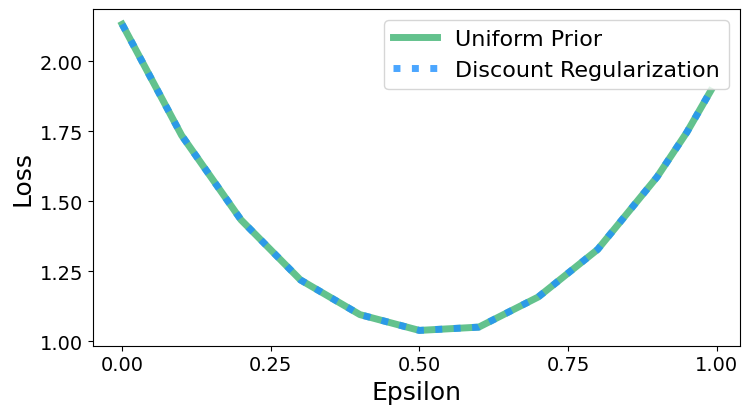

In [ ]:
#confirm uniform == discount in exact case
#set exact=True

epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
num_datasets = 10000
len_traj = 2
num_traj = 80

mean_loss_disc, mean_loss_eg, mean_loss_unif,stdev_loss_disc,stdev_loss_eg,stdev_loss_unif,loss_unif_ss_cv,loss_list_unif_ss_trueT,loss_unif_ss_mle,stdev_loss_ss_cv,stdev_loss_ss_trueT,stdev_loss_ss_mle = calc_loss(epsilon_list,num_traj,len_traj,num_datasets)

fig,ax = plt.subplots(1,1,figsize=(8,5))
#ax.plot(epsilon_list,eg_normalized,label = 'Epsilon-Greedy',alpha=.5,linewidth = 5.0,color='navy')
ax.plot(epsilon_list,mean_loss_unif,label = 'Uniform Prior',alpha=.8,linewidth = 5.0,color='mediumseagreen')
#ax.errorbar(epsilon_list, mean_loss_unif, yerr=[2*j for j in stdev_loss_unif])
ax.plot(epsilon_list,mean_loss_disc,label = 'Discount Regularization',alpha=.8,linewidth = 5.0,color='dodgerblue',linestyle='dotted')
#ax.errorbar(epsilon_list, mean_loss_disc, yerr=[2*j for j in stdev_loss_disc])
#ax.axhline(y=loss_unif_ss_cv, color='#2AA296', linestyle='-',linewidth = 5.0,alpha = .75, label = r"State-action specfic $\epsilon$ (estimated T)")
#ax.axhline(y=loss_list_unif_ss_trueT, color='teal', linestyle='-',linewidth = 5.0,alpha = .75, label = r"State-action specfic $\epsilon$ (true T)")
ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)

fig.tight_layout(rect=[0.05, 0, 1, 0.85])

In [ ]:
#set exact=false to compare discount regularization and uniform prior under uneven exploration

epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
num_datasets = 5000
len_traj = 2
num_traj = 80

mean_loss_disc, mean_loss_eg, mean_loss_unif,stdev_loss_disc,stdev_loss_eg,stdev_loss_unif,loss_unif_ss_cv,loss_list_unif_ss_trueT,loss_unif_ss_mle,stdev_loss_ss_cv,stdev_loss_ss_trueT,stdev_loss_ss_mle = calc_loss(epsilon_list,num_traj,len_traj,num_datasets)

0
10
20
30
40
50
60
70
80
90
100
110


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
229

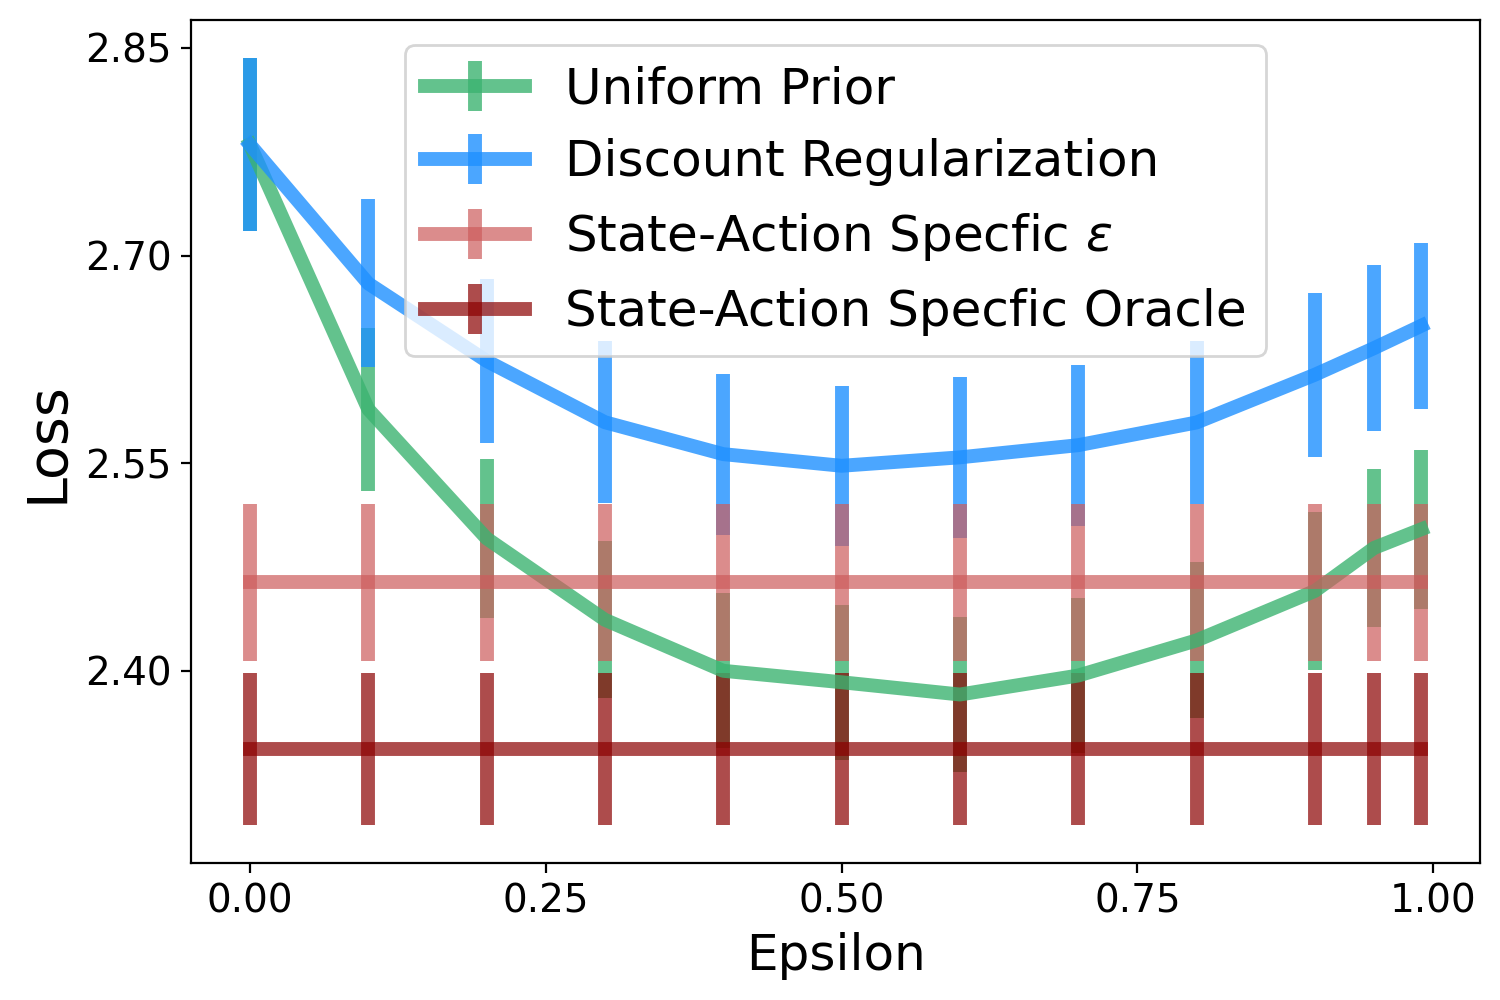

In [ ]:
#plot

fig,ax = plt.subplots(1,1,figsize=(8,6), dpi=200)
ax.errorbar(epsilon_list, mean_loss_unif, yerr=[2*j for j in stdev_loss_unif],label = 'Uniform Prior',alpha=.8,linewidth = 5.0,color='mediumseagreen')
ax.errorbar(epsilon_list, mean_loss_disc, yerr=[2*j for j in stdev_loss_disc],label = 'Discount Regularization',alpha=.8,linewidth = 5.0,color='dodgerblue')
ax.errorbar(epsilon_list,[loss_unif_ss_cv for i in epsilon_list],yerr=[2*stdev_loss_ss_cv for j in epsilon_list],color='indianred',linewidth = 5.0,alpha = .7, label = r"State-Action Specfic $\epsilon$")
#ax.errorbar(epsilon_list,[loss_unif_ss_mle for i in epsilon_list],yerr=[2*stdev_loss_ss_mle for j in epsilon_list],color='teal',linewidth = 5.0,alpha = .7, label = r"State-action specfic $\epsilon$ (T-MLE plugin)")
ax.errorbar(epsilon_list,[loss_list_unif_ss_trueT for i in epsilon_list],yerr=[2*stdev_loss_ss_trueT for j in epsilon_list],color='darkred',linewidth = 5.0,alpha = .7, label = r"State-Action Specfic Oracle")

ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=18)

fig.tight_layout(rect=[0.05, 0, 1, 0.85])